In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


In [19]:
df = pd.read_csv('train.csv', index_col=0)
df.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,,,,,,,,,,,
1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
len(df['Product_ID'].value_counts())

3631

In [ ]:
# looks like Product id is better to be in index
#df = pd.read_csv('train.csv', index_col=[0,1])
#df.head()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 550068 entries, (1000001, P00069042) to (1006039, P00371644)
Data columns (total 10 columns):
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 44.1+ MB


## Basic Feature engineering

In [4]:
df['Gender'].value_counts()
# imbalance in Gender, must sub sample, or use nearest neighbours, SVR, 

M    414259
F    135809
Name: Gender, dtype: int64

In [5]:
df['Age'].value_counts()
# imbalance in Age, must sub sample, or use nearest neighbours, SVR,

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

In [6]:
df['GenAge'] = df[['Gender', 'Age']].apply(lambda r : r[0]+'-'+r[1], axis=1)
df['GenAgeOcc'] = df[['Gender', 'Age', 'Occupation']].apply(lambda r : r[0]+'-'+r[1]+'-'+str(r[2]), axis=1)
df['CityStay'] = df[['City_Category', 'Stay_In_Current_City_Years']].apply(lambda r : r[0]+'-'+r[1], axis=1)

In [14]:
df_pidmeans = df.groupby('Product_ID').mean()['Purchase'].rename('AvgPidPurchase')
df_pidmeans.head()

Product_ID
P00000142    11143.642361
P00000242    10551.851064
P00000342     5313.422131
P00000442     4795.358696
P00000542     5417.530201
Name: AvgPidPurchase, dtype: float64

In [15]:
df_pc_means = df.groupby('Product_Category_1').mean()['Purchase'].rename('AvgProdcatPurchase')
df_pc_means.head()

Product_Category_1
1    13606.218596
2    11251.935384
3    10096.705734
4     2329.659491
5     6240.088178
Name: AvgProdcatPurchase, dtype: float64

In [21]:
df_fe = df.join(df_pidmeans, on='Product_ID')
df_fe = df_fe.join(df_pc_means, on='Product_Category_1')
df_fe.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AvgPidPurchase,AvgProdcatPurchase
User_ID,,,,,,,,,,,,,
1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,11870.863436,10096.705734
1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,16304.030981,13606.218596
1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,1237.892157,1350.859894
1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,1455.140762,1350.859894
1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,7692.763547,7498.958078


In [22]:
df_fe['DiffPurchaseMeanPid'] = df_fe['Purchase'] - df_fe['AvgPidPurchase'] 
df_fe['DiffPurchaseMeanPCat'] = df_fe['Purchase'] - df_fe['AvgProdcatPurchase'] 

In [23]:
df_fe['Product_Category_1'].value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64

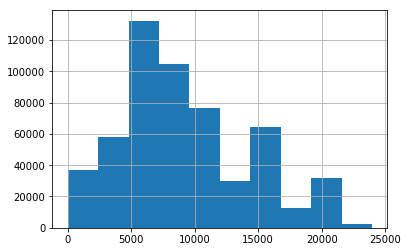

In [25]:
%matplotlib inline 
df_fe['Purchase'].hist()

In [30]:
bins = [0,2500,7500,12500,17500]
df_fe['PurchBin'] = pd.cut(df['Purchase'], bins=bins)

(7500, 12500]     191874
(2500, 7500]      191874
(12500, 17500]     85416
(0, 2500]          36844
Name: PurchBin, dtype: int64

## EDA

In [17]:
df['Purchase'].plot.box()

## Models

In [37]:
df_filled = df.fillna(0)

In [38]:
train_df = pd.get_dummies(df_filled)
train_df.columns

Index([u'Occupation', u'Marital_Status', u'Product_Category_1',
       u'Product_Category_2', u'Product_Category_3', u'Purchase', u'Gender_F',
       u'Gender_M', u'Age_0-17', u'Age_18-25',
       ...
       u'CityStay_B-0', u'CityStay_B-1', u'CityStay_B-2', u'CityStay_B-3',
       u'CityStay_B-4+', u'CityStay_C-0', u'CityStay_C-1', u'CityStay_C-2',
       u'CityStay_C-3', u'CityStay_C-4+'],
      dtype='object', length=293)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df[train_df.columns.difference(['Purchase'])], train_df['Purchase'], test_size=0.25)

In [40]:
## try 1st RandomForest to get a basic feeling about what maybe important

regr = RandomForestRegressor(max_depth=10, random_state=123, n_jobs=-1)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [41]:
pd.DataFrame({'col':X_train.columns, 'imp':regr.feature_importances_}).sort_values('imp', ascending=False).head(10)

,col,imp
284,Product_Category_1,0.964473
285,Product_Category_2,0.011808
286,Product_Category_3,0.008714
24,City_Category_C,0.004279
283,Occupation,0.000862
282,Marital_Status,0.000297
267,GenAge_F-18-25,0.000288
5,Age_51-55,0.000254
23,City_Category_B,0.000212
137,GenAgeOcc_M-0-17-10,0.000201


In [42]:
Y_pred = regr.predict(X_test)
sqrt(mean_squared_error(Y_test, Y_pred))

2930.954869283203

# KNN regression

In [43]:
# maybe a nearest neigbours, instance learning uses thedata itself to predict
from sklearn.neighbors import KNeighborsRegressor
regrKnn = KNeighborsRegressor(n_jobs=-1)
regrKnn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

In [44]:
Y_pred = regrKnn.predict(X_test)
sqrt(mean_squared_error(Y_test, Y_pred))

3433.539212127567

## SVR regression

In [ ]:
from sklearn.svm import SVR
regrSVR = SVR(C=1.0, epsilon=0.2, max_iter=1000, verbose=True)
regrSVR.fit(X_train, Y_train)

In [ ]:
Y_pred = regrKnn.predict(X_test)
sqrt(mean_squared_error(Y_test, Y_pred))